## 问题描述
让神经网络学会能否被3整除操作

输入：任意一个整数

输出：能被3整除，输出“yes”，否则输出“no”

### 网络结构图

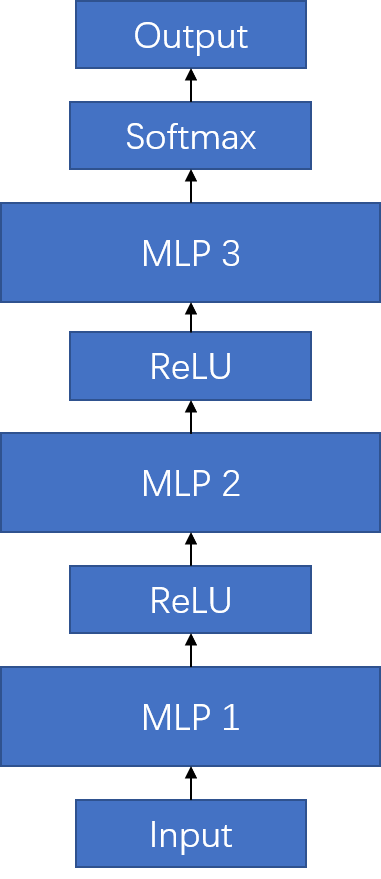

![mlp](https://zh-v2.d2l.ai/_images/mlp.svg)

## STEP 1：数据处理

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [3]:
# 构建编码器
def encode(number):
    if number % 3 == 0:
        return 1
    return 0

In [4]:
# 构建解码器
def decode(label):
    return ['no', 'yes'][label]

In [5]:
digit = 64

In [6]:
def to_bin(number):
    return np.array([number >> dim & 1 for dim in range(digit)][::-1])

In [7]:
def to_input(number):
    return torch.Tensor(to_bin(number))

In [8]:
data_max_val = 100000
val_sum = 500
test_sum = 1000

In [9]:
# 构建数据集
train_numbers = torch.Tensor([to_bin(number) for number in range(1, data_max_val)])
train_labels = torch.LongTensor([encode(number) for number in range(1, data_max_val)])

C:\Users\yxp\AppData\Local\Temp\ipykernel_24044\3711597908.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\Users\builder\tkoch\workspace\pytorch\pytorch_1647970138273\work\torch\csrc\utils\tensor_new.cpp:201.)
  train_numbers = torch.Tensor([to_bin(number) for number in range(1, data_max_val)])


In [10]:
import random

In [11]:
val_numbers = torch.Tensor([to_bin(number) for number in range(data_max_val, data_max_val + val_sum)])
val_labels = torch.LongTensor([random.randint(0, 1) for number in range(data_max_val, data_max_val + val_sum)])

In [12]:
test_numbers = torch.Tensor([to_bin(number) for number in range(data_max_val + val_sum + 1, data_max_val + val_sum + 1 + test_sum)])
test_labels = torch.LongTensor([encode(number) for number in range(data_max_val + val_sum + 1, data_max_val + val_sum+1 + test_sum)])

In [13]:
# 加载数据集
class TriDataset(data.Dataset):
    def __init__(self, numbers, labels):
        self.numbers = numbers
        self.labels = labels
    
    def __getitem__(self, idx):
        return self.numbers[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.numbers)

In [14]:
batchSize = 64

In [15]:
train_dataset = TriDataset(train_numbers, train_labels)
train_loader = data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)

In [16]:
val_dataset = TriDataset(val_numbers, val_labels)
val_loader = data.DataLoader(val_dataset, batch_size=batchSize, shuffle=True)

In [17]:
test_dataset = TriDataset(test_numbers, test_labels)
test_loader = data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

## STEP 2：构建模型

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
class TriModel(nn.Module):
    def __init__(self):
        super(TriModel, self).__init__()
        dim1 = int(digit)
        dim2 = int(dim1/4)
        dim3 = int(dim2/2)
        self.architecture = nn.Sequential(
            nn.Linear(dim1, dim2),
            nn.ReLU(),
            nn.Linear(dim2, dim3),
            nn.ReLU(),
            nn.Linear(dim3, 2)
        )

    def forward(self, x):
        return self.architecture(x)

In [20]:
model = TriModel().to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

## STEP 3：训练模型

In [21]:
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker

In [22]:
def draw(xaxis, yaxis, xlabel, ylabel, legend):
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.plot(xaxis, yaxis, label=legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend != None:
        plt.legend()
    plt.show()

train process: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


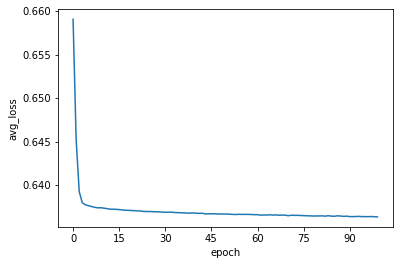

In [23]:
# train
epochs = 100
loss_lst = []

model.train()
for epoch in tqdm(range(epochs), desc='train process'):
    loss_sum = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_f(pred, y)

        loss_sum = loss_sum + loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_lst.append(float((loss_sum / len(train_loader)).detach()))
draw(list(range(epochs)), loss_lst, 'epoch', 'avg_loss', None)

In [23]:
# validate
val_epoch = 10

min_loss = 99999
good_idx = -1

model.eval()
for epoch in tqdm(range(val_epoch), desc='val process'):
    loss_sum = 0
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        loss = loss_f(pred, y)
        loss_sum = loss_sum + loss
    avg_loss = loss_sum/epochs
    if avg_loss < min_loss:
        min_loss = avg_loss
        good_idx = i
        torch.save(model, './model.bin')

val process: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [25]:
# test
best_model = torch.load('./model.bin').to(device)
softmax = nn.Softmax(0)

f1 = 0
acc = 0

for i, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)

    pred = np.argmax(softmax(best_model(x)).cpu().detach().numpy(), 1)
    y = np.array(y.cpu().detach().numpy())
    f1 = f1 + f1_score(y, pred)
    acc = acc + accuracy_score(y, pred)

f1 = f1 / len(test_loader)
acc = acc / len(test_loader)

print('acc:', acc, 'f1:', f1)

acc: 0.50703125 f1: 0.3978082611997896


## 使用训练好的模型

In [26]:
val = -3
output = best_model(to_input(val).to(device))
output = softmax(output)
output = np.argmax(output.cpu().detach().numpy(), 0)

decode(output)

'no'

In [27]:
val = -4
output = best_model(to_input(val).to(device))
output = softmax(output)
output = np.argmax(output.cpu().detach().numpy(), 0)

decode(output)

'no'